In [1]:
import time, copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.special import comb

In [2]:
def gauss(x, b=0, c=1):
    return np.exp(-(x-b)**2/(2*c**2))

def gauss_kx(x, kx, b=0, c=1):
    return gauss(x, b, c) * np.exp(1j * kx * x)

def get_BC_kx(x_0, x_max, x_step, kx, beam_center=0, waist=1):
    BC = [gauss_kx(x, kx, beam_center, waist) for x in np.arange(x_0, x_max, x_step)]
    return np.array(BC)

In [3]:
def n_to_Veff(n_of_x, k):
    return 0.5 * k * (np.array(n_of_x)**2 - 1)

In [4]:
def n_sqr_well(x, x_star=2.5):
    coef = np.power(0.005, 1/4) / x_star
    if np.abs(x) <= x_star:
        val = 1 + (coef * x)**4
    else:
        val = 1.005
    return val

def n_step0(x, a=1):
    return 0.25 * np.tanh(a*x) + 1.25

def n_step1(x, a=1):
    return 0.25 * np.tanh(-a*x) + 1.25

def n_step_sharp0(x, midpoint=0):
    if x < midpoint:
        return 1
    else:
        return 1.5
    
def n_step_sharp1(x, midpoint=0):
    if x > midpoint:
        return 1
    else:
        return 1.5

def dEdz_vec(E, x, k, n_of_x, ddx):
    V_eff = n_to_Veff(n_of_x, k)
    return (((-V_eff * E) - ddx/(2*k)) / 1j)

def RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_of_x, smooth_val):
    # list of zvals
    z_list = np.arange(z_0, z_max, z_step)
    
    # list of xvals
    x_list = np.arange(x_0, x_max, x_step)
        
    # grid of E vals starts as just the boundary conditions
    E_grid = [BC]
    
    # beam power
    p0 = np.sum(np.abs(BC))
    
    # loop over z's
    for i in tqdm(range(int((z_max - z_0) / z_step))):
        # 1st derivative
        der_1 = np.gradient(E_grid[i], x_step, edge_order=1)
        
        # 2nd derivative
        der_vals = np.gradient(der_1, x_step, edge_order=1)
        
        # V effective
        v_eff = n_to_Veff(n_of_x, kz)
        
        k1_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals)
        k2_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + 0.5 * k1_vec)
        k3_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + 0.5 * k2_vec)
        k4_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + k3_vec)
        
        new_slice = E_grid[i] + k1_vec/6 + k2_vec/3 + k3_vec/3 + k4_vec/6
        
        new_pwr = np.sum(np.abs(new_slice))
        
        if np.abs(1 - (new_pwr / p0)) > 1.2:
            print(p0, new_pwr)
            print(i, i*z_step)
            break

        E_grid.append(new_slice)
        
    # 64 bit floats instead of 128 to help memory usage
    return np.array(E_grid, dtype=np.complex64)

In [5]:
def get_angle(k, kx):
    return np.arcsin(kx / k)

def get_kz(k, angle):
    return np.cos(angle) * k

In [16]:
# physical params
lam0 = 200 * 10**(-3) # micrometers
# lam = 200 * 10**(-9) # meters
k0 = 2*np.pi/lam0

lam1 = lam0 / 1.5
k1 = 2*np.pi/lam1

# beam params (micrometers)
beam_center = -4
waist = 1

# spatial params (micrometers)
x_step = 10**(-1)
x_0 = -6
x_max = 6

z_step = 1*10**(-3)
z_0 = 0
z_max = 1*10**(2)
hlim = z_max / z_step

kxs = np.arange(0, 1, 0.02)

angles = get_angle(k0, kxs)
kzs0 = get_kz(k0, angles)
kzs1 = get_kz(k1, angles)

x_list = np.arange(x_0, x_max, x_step)

In [17]:
big_angle = 10 * np.pi / 180
big_kx0 = np.sin(big_angle) * k0
big_kz0 = np.cos(big_angle) * k0

big_kx1 = np.sin(big_angle) * k1
big_kz1 = np.cos(big_angle) * k1

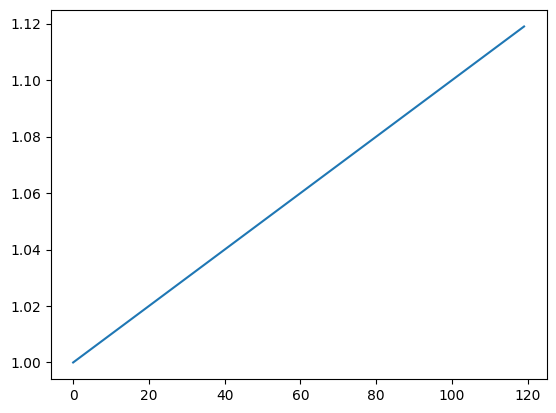

In [22]:
def linear_n(x):
    return 1.06 + (z_step / x_step) * x

n_lin = [linear_n(x) for x in x_list]

plt.plot(n_lin)
# n lists
n_well_list = np.array([n_sqr_well(x) for x in x_list])
n_free = [1 for x in x_list]
n_glass0 = n_step0(x_list, a=2)
n_glass_sharp0 = [n_step_sharp0(x) for x in x_list]

n_glass1 = n_step1(x_list, a=2)
n_glass_sharp1 = [n_step_sharp1(x) for x in x_list]

s_val = 25
p_val = 7
ss_val = 5
n_smooth = savgol_filter(n_well_list, s_val, p_val)
n_ss = uniform_filter1d(n_smooth, ss_val)

In [23]:
# plt.plot(n_well_list)
# plt.plot(n_free)
# plt.plot(n_glass1)
# plt.plot(n_glass_sharp)

In [24]:
# kxs, kzs

 65%|███████████████████████████████████████████████▏                         | 64597/100000 [00:09<00:05, 6678.21it/s]


24.561433936683407 54.03629038085002
64597 64.59700000000001
wavenumber (um^(-1)): 0.0


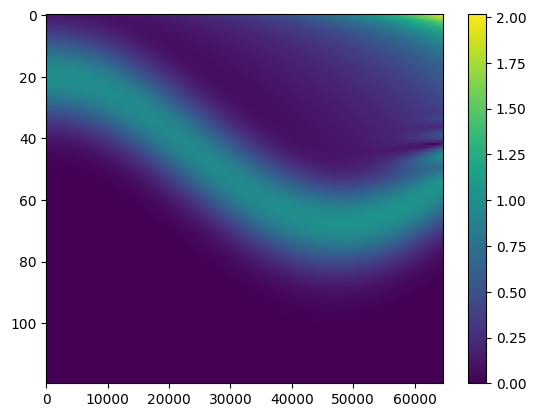

In [25]:
# very slowly changing n, angle = 0

idx = 0

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_lin, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:25<00:00, 6890.61it/s]


wavenumber (um^(-1)): 0.0


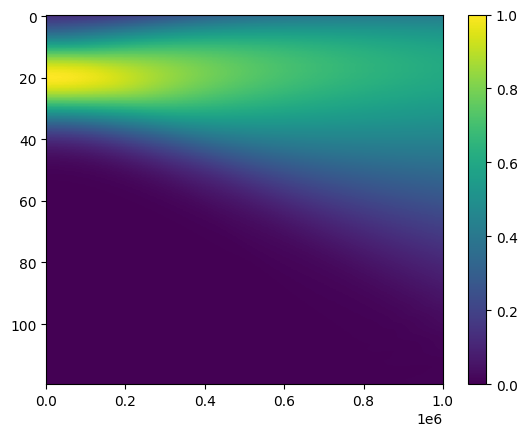

In [183]:
# uniform index of refraction n=1, no angle
# works as expected
idx = 0

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_free, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

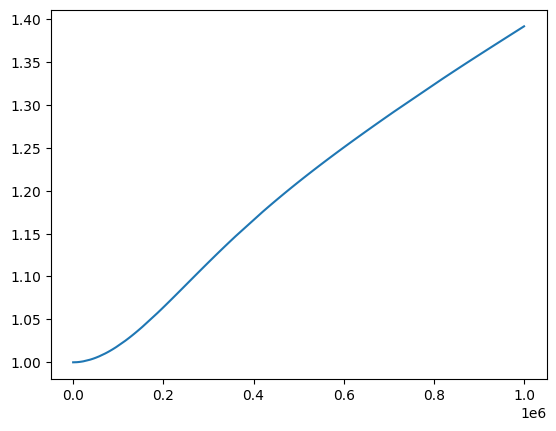

In [187]:
pwr = [np.sum(np.abs(E_grid0[i])) for i in range(len(E_grid0))]
plt.plot(pwr / np.sum(np.abs(E_grid0[0])))

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:26<00:00, 6845.00it/s]


wavenumber (um^(-1)): 0.98


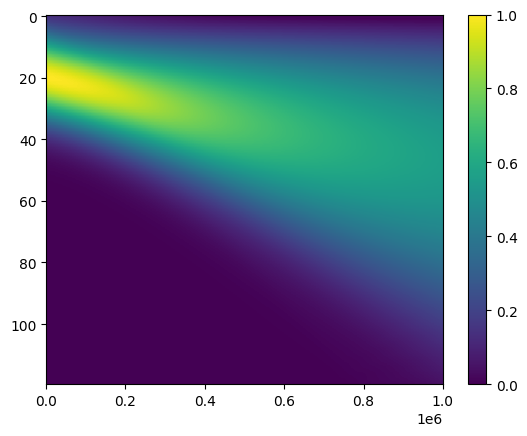

In [188]:
# n = 1, angle = 0.031
# works as expected

idx = -1

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_free, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

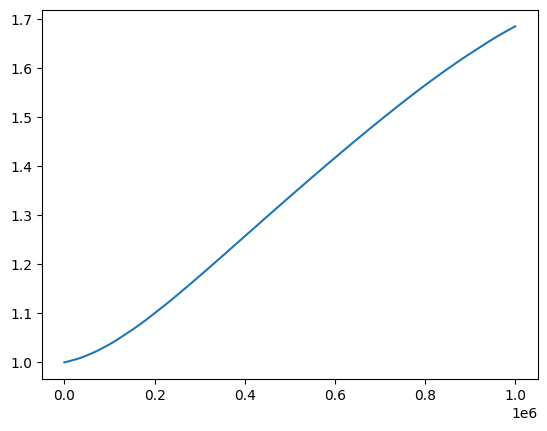

In [189]:
pwr = [np.sum(np.abs(E_grid0[i])) for i in range(len(E_grid0))]
plt.plot(pwr / np.sum(np.abs(E_grid0[0])))

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [00:40<00:00, 9785.67it/s]


wavenumber (um^(-1)): 0.0


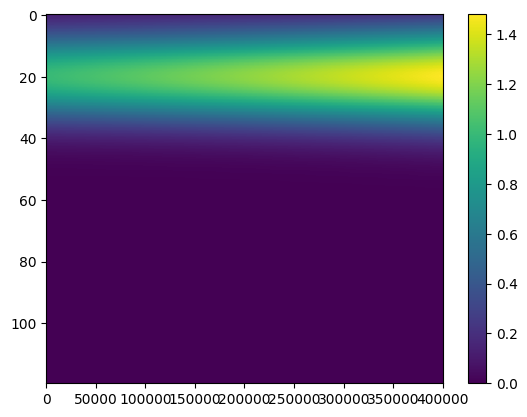

In [107]:
# n = 1.5, angle = 0

idx = 0

kx = kxs[idx]
kz = kzs1[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, 1.5, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

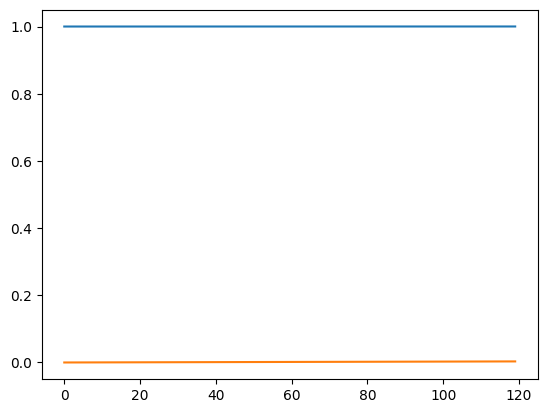

In [108]:
pwr = [np.sum(np.abs(E_grid0[i])) for i in range(len(E_grid0.T))]
plt.plot(pwr / np.sum(np.abs(E_grid0[0])))
plt.plot(pwr - np.sum(np.abs(E_grid0[0])))

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [00:50<00:00, 7961.05it/s]


wavenumber (um^(-1)): 0.0


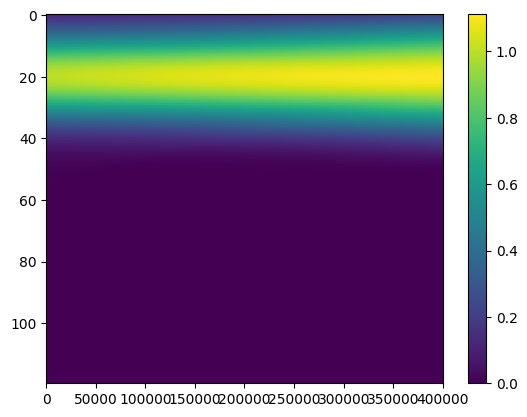

In [109]:
# air to glass, angle = 0

idx = 0

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

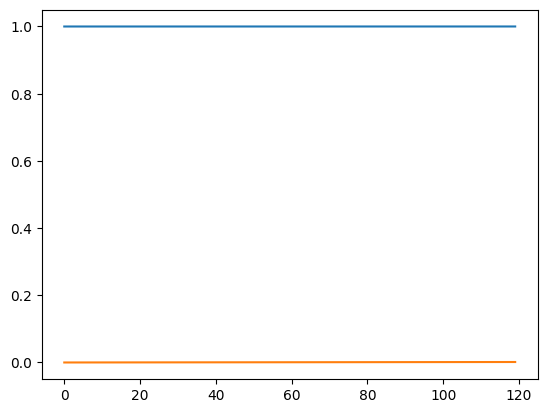

In [110]:
pwr = [np.sum(np.abs(E_grid0[i])) for i in range(len(E_grid0.T))]
plt.plot(pwr / np.sum(np.abs(E_grid0[0])))
plt.plot(pwr - np.sum(np.abs(E_grid0[0])))

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [01:02<00:00, 6354.65it/s]


wavenumber (um^(-1)): 0.0


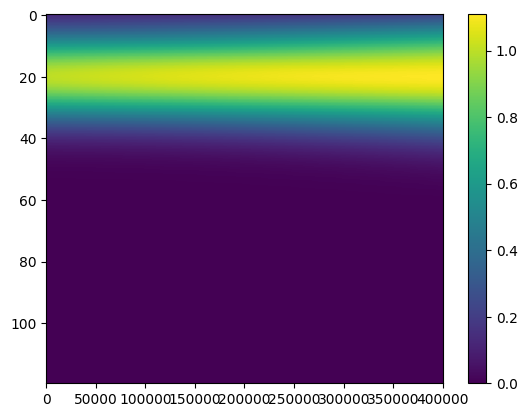

In [111]:
# air to glass, angle = 0 n_glass_sqr
# works

idx = 0

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass_sharp, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

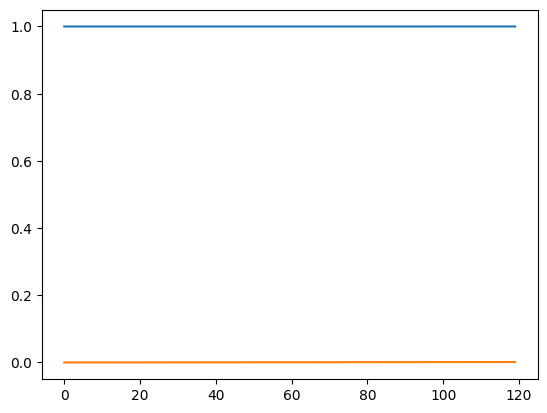

In [112]:
pwr = [np.sum(np.abs(E_grid0[i])) for i in range(len(E_grid0.T))]
plt.plot(pwr / np.sum(np.abs(E_grid0[0])))
plt.plot(pwr - np.sum(np.abs(E_grid0[0])))

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [00:50<00:00, 7972.72it/s]


wavenumber (um^(-1)): 0.98


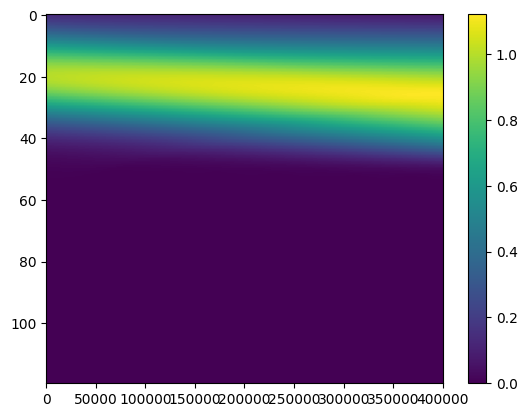

In [113]:
# air to glass, angle = 0.031
# doesn't work

idx = -1

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

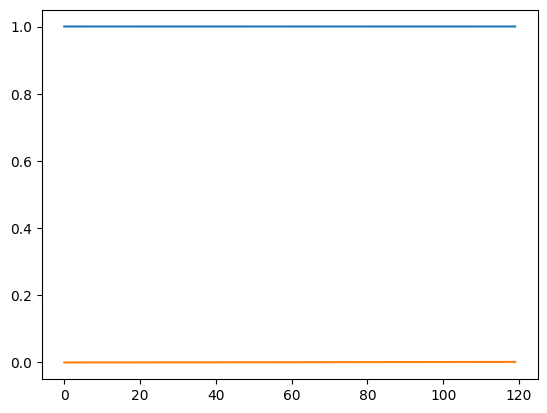

In [114]:
pwr = [np.sum(np.abs(E_grid0[i])) for i in range(len(E_grid0.T))]
plt.plot(pwr / np.sum(np.abs(E_grid0[0])))
plt.plot(pwr - np.sum(np.abs(E_grid0[0])))

 53%|█████████████████████████████████████▌                                 | 528816/1000000 [01:06<00:59, 7973.47it/s]


24.561433936683407 54.035734821600045
528816 52.881600000000006
wavenumber (um^(-1)): 5.455318392676835


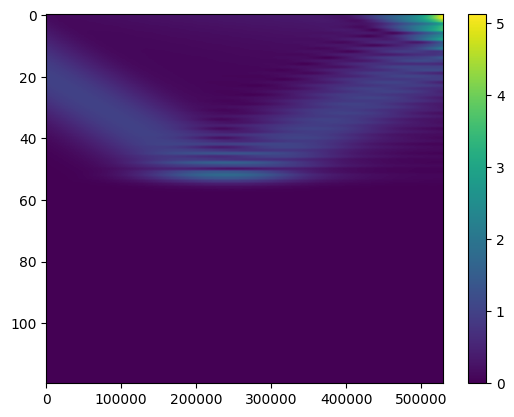

In [164]:
# air to glass, angle = 0.174 rad
# doesnt work

idx = -1

kx = big_kx
kz = big_kz

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass0, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

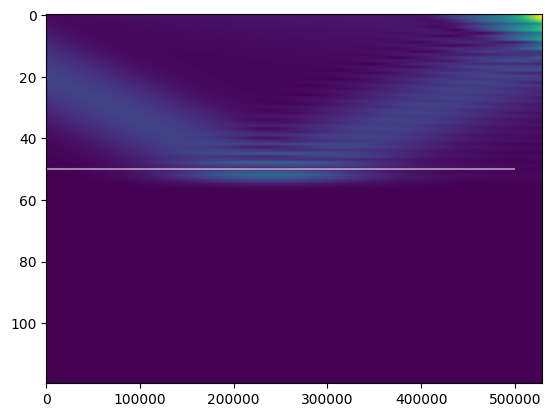

In [165]:
plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.hlines(50, 0, 0.5*z_max / z_step, color="white", alpha=0.5)

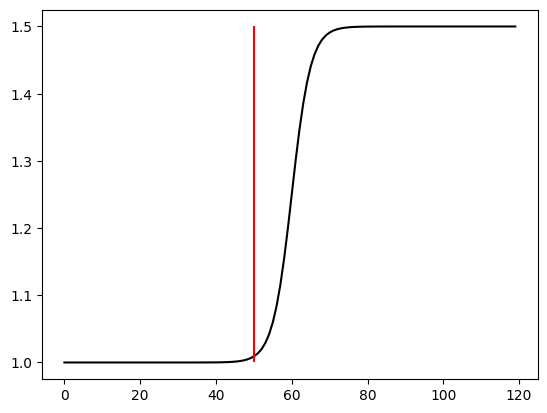

In [166]:
plt.plot(n_glass0, c="0")
plt.vlines(50, 1, 1.5, color="r")

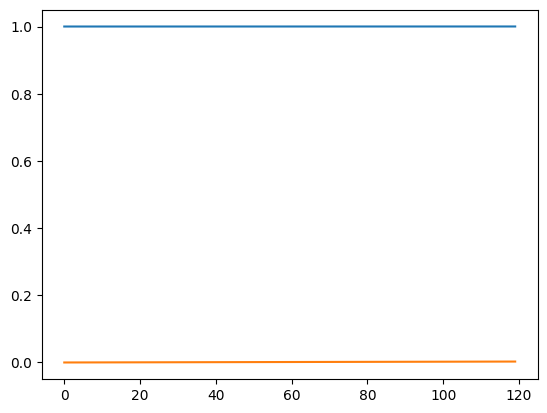

In [167]:
pwr = [np.sum(np.abs(E_grid0[i])) for i in range(len(E_grid0.T))]
plt.plot(pwr / np.sum(np.abs(E_grid0[0])))
plt.plot(pwr - np.sum(np.abs(E_grid0[0])))

 37%|██████████████████████████                                             | 367638/1000000 [00:46<01:19, 7989.87it/s]


24.561433936683407 54.03517983481367
367638 36.7638
wavenumber (um^(-1)): 5.455318392676835


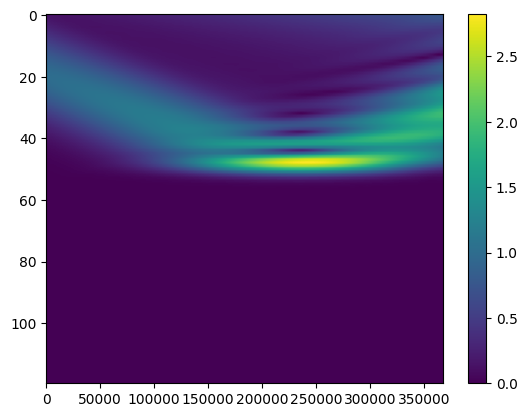

In [168]:
# air to glass, angle = 0.174
# doesnt work

idx = -1

kx = big_kx
kz = big_kz

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass1, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

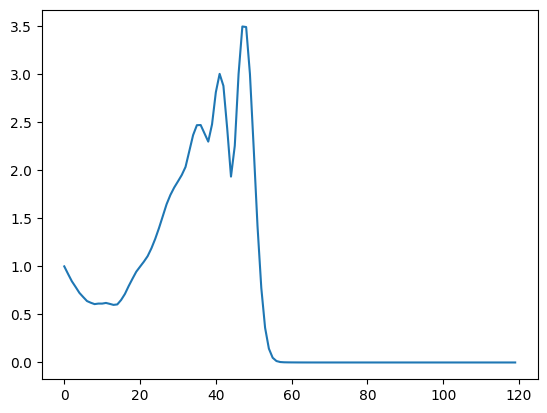

In [179]:
pwr = [np.sum(np.abs(E_grid0.T[i])) for i in range(len(E_grid0.T))]
plt.plot(pwr / np.sum(np.abs(E_grid0.T[0])))

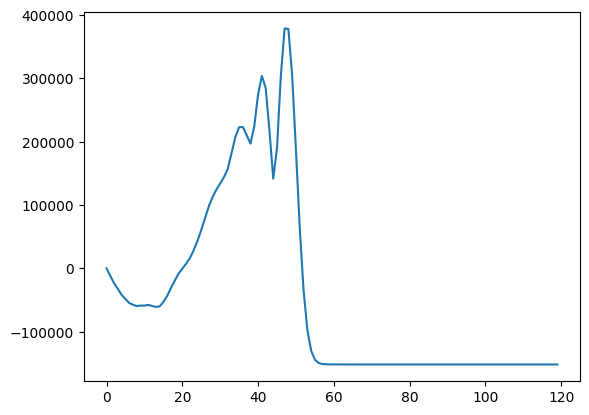

In [181]:
plt.plot(pwr - np.sum(np.abs(E_grid0.T[0])))

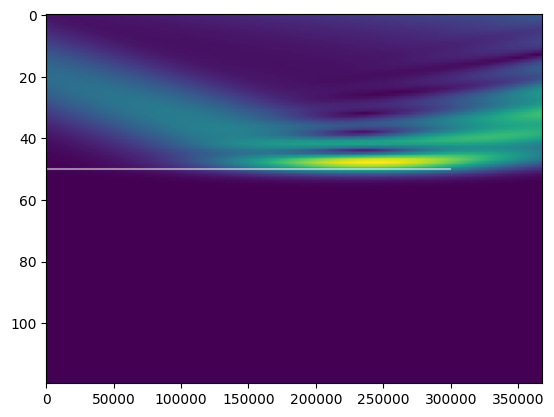

In [170]:
plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.hlines(50, 0, 0.3*z_max / z_step, color="white", alpha=0.5)

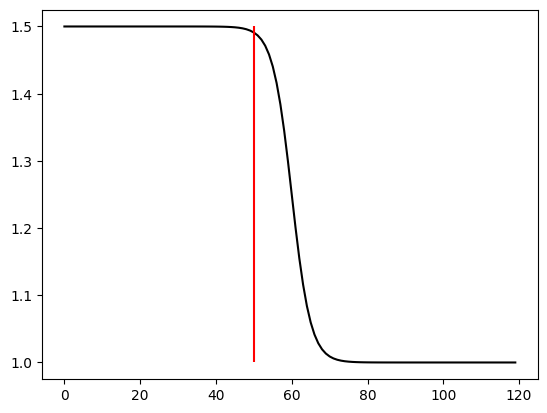

In [171]:
plt.plot(n_glass1, c="0")
plt.vlines(50, 1, 1.5, color="r")

In [191]:
big_angle * 180 / np.pi

10.0